In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/CelebA.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/CelebA_Data')

In [ ]:
with zipfile.ZipFile('/content/CelebA_Data/CelebA/Img/img_align_celeba.zip','r') as zip_ref_img:
  zip_ref_img.extractall('/content/celebImages')

In [ ]:
import zipfile
import random
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import PIL
import os
import cv2
from torch import optim
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchsummary import summary
import matplotlib.pyplot as plt

In [ ]:
img_dir = '/content/celebImages/img_align_celeba'
transform = transforms.Compose([transforms.Grayscale(), 
                                         transforms.ToTensor(),
                                         transforms.Resize((28,28)), 
                                         transforms.Normalize(0,0.5)])
label_file = '/content/CelebA_Data/CelebA/Anno/identity_CelebA.txt'
batch_size = 4

In [ ]:
df = pd.read_csv(label_file, sep=" ", header=None)
df.columns = ["name", "ID"]

In [ ]:
print(df)

              name     ID
0       000001.jpg   2880
1       000002.jpg   2937
2       000003.jpg   8692
3       000004.jpg   5805
4       000005.jpg   9295
...            ...    ...
202594  202595.jpg   9761
202595  202596.jpg   7192
202596  202597.jpg   9852
202597  202598.jpg   5570
202598  202599.jpg  10101

[202599 rows x 2 columns]


In [ ]:
ids=df.ID.unique()
print(ids)
print(len(ids))

[2880 2937 8692 ... 5723 7942 5335]
10177


In [ ]:
arr=[]
for i in range(120):
  arr.append(ids[i])
print(arr)

[2880, 2937, 8692, 5805, 9295, 4153, 9040, 6369, 3332, 612, 2807, 7779, 3785, 7081, 1854, 4905, 667, 2464, 2929, 2782, 181, 6642, 1, 9290, 7578, 10046, 4128, 3670, 3422, 8216, 9181, 268, 7600, 1603, 5512, 3272, 8744, 4407, 6446, 2088, 1058, 5230, 5239, 2079, 4125, 6318, 9177, 4310, 6817, 1446, 3896, 9397, 8443, 4883, 545, 10144, 2879, 6204, 6880, 3316, 1499, 1539, 3629, 3046, 3792, 1175, 5300, 4627, 3403, 9289, 5604, 7880, 266, 640, 184, 13, 8671, 6625, 3286, 9642, 2192, 4385, 5127, 6145, 5689, 5578, 5472, 6622, 4915, 4876, 7399, 4960, 2410, 4262, 6530, 5927, 8289, 6746, 4988, 7191, 273, 4323, 1946, 5794, 8833, 4929, 3325, 4731, 9474, 5950, 821, 7256, 6802, 4887, 2678, 6938, 9605, 4500, 3705, 999]


In [ ]:
print(len(arr))

120


In [ ]:
os.makedirs('data', exist_ok=True)
os.makedirs('data/test', exist_ok=True)
os.makedirs('data/validate', exist_ok=True)
os.makedirs('data/train', exist_ok=True)

In [ ]:
df_map = {}
for i in arr:
  # find imgs belonging to class i
  id_df = df.loc[df.ID == i]

  # create image list
  img_list = id_df.name.to_list()
  #print(img_list)
  df_map[i] = img_list

print(df_map)
print(len(df_map))

{2880: ['000001.jpg', '000404.jpg', '003415.jpg', '004390.jpg', '018062.jpg', '025244.jpg', '027771.jpg', '039393.jpg', '047978.jpg', '049142.jpg', '052385.jpg', '052623.jpg', '053184.jpg', '053311.jpg', '055834.jpg', '058188.jpg', '061431.jpg', '068154.jpg', '084705.jpg', '090937.jpg', '096324.jpg', '100990.jpg', '103728.jpg', '108341.jpg', '110376.jpg', '122439.jpg', '131731.jpg', '134007.jpg', '139106.jpg', '140935.jpg'], 2937: ['000002.jpg', '011437.jpg', '016335.jpg', '017121.jpg', '024291.jpg', '037082.jpg', '045318.jpg', '046844.jpg', '048360.jpg', '055891.jpg', '057357.jpg', '058209.jpg', '058400.jpg', '059638.jpg', '060925.jpg', '063242.jpg', '063616.jpg', '066809.jpg', '077346.jpg', '095867.jpg', '099877.jpg', '105287.jpg', '108661.jpg', '114336.jpg', '114625.jpg', '117710.jpg', '120280.jpg', '125140.jpg', '142601.jpg', '152380.jpg'], 8692: ['000003.jpg', '015648.jpg', '033840.jpg', '038887.jpg', '049972.jpg', '052374.jpg', '053297.jpg', '061069.jpg', '069458.jpg', '070480.jp

In [ ]:
for i in df_map.keys():
    train_size = math.floor((0.7) * len(df_map[i]))
    validate_size = math.floor((0.15) * len(df_map[i]))
    test_size = math.floor((0.15) * len(df_map[i]))
    # create image list
    img_list = df_map[i]

    imglist_train = img_list[0:train_size]
    imglist_validate=img_list[train_size-1:train_size+validate_size]
    imglist_test = img_list[train_size+validate_size-1:train_size+test_size+validate_size]

    print(img_list)

    os.makedirs(os.path.join('data/train', str(i)), exist_ok=True)
    os.makedirs(os.path.join('data/validate', str(i)),exist_ok=True)
    os.makedirs(os.path.join('data/test', str(i)),exist_ok=True)

    for img in imglist_train:

      image = cv2.imread(os.path.join("/content/celebImages/img_align_celeba",img))
      # saving image in the relevant directory
      cv2.imwrite(os.path.join('data/train',str(i),img), image)

    for img in imglist_validate:

      image = cv2.imread(os.path.join("/content/celebImages/img_align_celeba",img))
      # saving image in the relevant directory
      cv2.imwrite(os.path.join('data/validate',str(i),img), image)


    for img in imglist_test:

      image = cv2.imread(os.path.join("/content/celebImages/img_align_celeba",img))
      # saving image in the relevant directory
      cv2.imwrite(os.path.join('data/test',str(i),img), image)


['000001.jpg', '000404.jpg', '003415.jpg', '004390.jpg', '018062.jpg', '025244.jpg', '027771.jpg', '039393.jpg', '047978.jpg', '049142.jpg', '052385.jpg', '052623.jpg', '053184.jpg', '053311.jpg', '055834.jpg', '058188.jpg', '061431.jpg', '068154.jpg', '084705.jpg', '090937.jpg', '096324.jpg', '100990.jpg', '103728.jpg', '108341.jpg', '110376.jpg', '122439.jpg', '131731.jpg', '134007.jpg', '139106.jpg', '140935.jpg']
['000002.jpg', '011437.jpg', '016335.jpg', '017121.jpg', '024291.jpg', '037082.jpg', '045318.jpg', '046844.jpg', '048360.jpg', '055891.jpg', '057357.jpg', '058209.jpg', '058400.jpg', '059638.jpg', '060925.jpg', '063242.jpg', '063616.jpg', '066809.jpg', '077346.jpg', '095867.jpg', '099877.jpg', '105287.jpg', '108661.jpg', '114336.jpg', '114625.jpg', '117710.jpg', '120280.jpg', '125140.jpg', '142601.jpg', '152380.jpg']
['000003.jpg', '015648.jpg', '033840.jpg', '038887.jpg', '049972.jpg', '052374.jpg', '053297.jpg', '061069.jpg', '069458.jpg', '070480.jpg', '073665.jpg', '07

In [ ]:
import shutil
shutil.rmtree("/content/data", ignore_errors=True)

In [ ]:
from torch import nn
import torch.nn.functional as F



class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1, # gray-scale images           
                out_channels=16,            
                kernel_size=5, # 5x5 convolutional kernel               
                stride=1,  #no. of pixels pass at a time                 
                padding=2, # to preserve size of input image                 
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layers
        self.out = nn.Linear(1568, 120)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 
        x = x.view(x.size(0), -1)    
        output = self.out(x)
        output = F.log_softmax(output,dim=1)
        return output
cnn=CNN()
cnn
print(cnn)
# self.fc1 = nn.Linear(28*28, 500)
# self.fc2 = nn.Linear(500, 320)
# self.fc3 = nn.Linear(320, 200)
# self.fc4 = nn.Linear(200, 120)
#   def forward(self, x):
#     x = torch.flatten(x, 1) # flatten all dimension except batch
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = F.relu(self.fc3(x))
#     x = self.fc4(x)
#     return x

#net = Net()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=120, bias=True)
)


NameError: ignored

In [ ]:
#print(net)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=320, bias=True)
  (fc3): Linear(in_features=320, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=120, bias=True)
)


In [ ]:
from torch import optim

# loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(cnn.parameters(), lr = 0.001) 

In [ ]:
train_set = datasets.ImageFolder('/content/data/train', 
                                 transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

validate_set = datasets.ImageFolder('/content/data/validate', 
                                 transform=transform)
validate_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = datasets.ImageFolder('/content/data/test', 
                                transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(train_size)

20


In [ ]:
from torch.autograd import Variable
total_epochs = 4
total_step = len(train_loader)
train_loss = []
valid_loss=[]
for epoch in range(total_epochs): # iterate over epochs
  epoch_loss = 0
  for i, (images, labels) in enumerate(validate_loader):
        # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    # inputs, labels = data
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    bx = Variable(images)   # batch x
    by = Variable(labels)   # batch y
    # Zero-out gradients
    optimizer.zero_grad()
    # print(inputs.get_device())
    # print(labels.get_device())

    # # forward + backward + optimize
    outputs = cnn(bx)
    loss = criterion(outputs, by)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  for i, (images, labels) in enumerate(train_loader):
      # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    # inputs, labels = data
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    bx = Variable(images)   # batch x
    by = Variable(labels)   # batch y
    # Zero-out gradients
    optimizer.zero_grad()
    # print(inputs.get_device())
    # print(labels.get_device())

    # # forward + backward + optimize
    outputs = cnn(bx)
    loss = criterion(outputs, by)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    if (i+1) % 500 == 0:
      print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, total_epochs, i+1, total_step, loss.item()))
  valid_loss.append(epoch_loss)
  

Epoch [1/4], Step [500/525], Loss: 4.7634
Epoch [2/4], Step [500/525], Loss: 4.8170
Epoch [3/4], Step [500/525], Loss: 4.7879
Epoch [4/4], Step [500/525], Loss: 4.7518


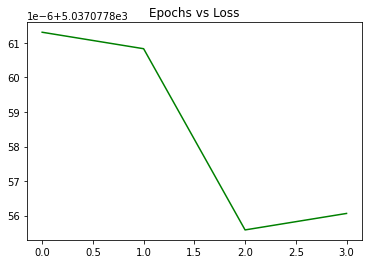

In [ ]:
plt.plot(train_loss,color='red')
plt.plot(valid_loss,color='green')
plt.title('Epochs vs Loss')
plt.show()

ValueError: ignored

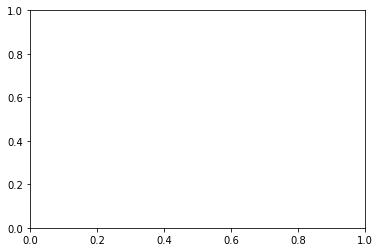

In [ ]:
plt.plot([1,2,3,4], train_loss)
plt.title('Epochs vs Loss')
plt.show()

In [ ]:
dataiter = iter(test_loader)
images, test_labels = dataiter.next()

In [ ]:
# test trained model
test_out = cnn(images.to(device))
test_out.shape

torch.Size([4, 120])

In [ ]:
# Finding predicted class
_, pred = torch.max(test_out, 1) 
pred

tensor([56, 13, 13, 71])

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = cnn(images)
         # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item() 
acc = 100.0 * n_correct / n_samples
print(f'Accuracy on test images: {acc} %') 

Accuracy on test images: 0.5747126436781609 %
